In [84]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import math
import sys
from pathlib import Path
import seaborn as sns

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import *
from src.data.clean_data import *

IMPORTANT: these scripts/functions assume you have the following files in the data/raw directory:
- From the CMU dataset: 
    - movie.metadata.tsv
    - plot_summaries.txt
- From the TMDB dataset: 
    - TMDB_movie_dataset_v11.csv

AND have data/processed folder created

Note: download CMU dataset here: https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
and TMDB dataset here (Download button): https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies

In [85]:
# from raw files, creates clean datafiles
%run src/data/clean_data.py

sep ,
headers []
original df shape (1127777, 24)
after status (1102507, 24)
after release date (760210, 24)
after release year (760210, 25)
after duplicates (745861, 25)
after numeric columns (745860, 25)
after select columns (745860, 13)
sep 	
headers ['wikipedia_movie_id', 'freebase_ID', 'title', 'release_year', 'revenue', 'runtime', 'languages', 'countries', 'genres']
original df shape (81740, 9)
after status (81740, 9)
after release date (81740, 9)
after release year (44006, 9)
after duplicates (43915, 9)
after numeric columns (43915, 9)
after select columns (43915, 5)


In [229]:
# from clean data files, creates a dataframe with CMU + plots & TMDB movies 
%run src/data/process_data.py
df_combined = create_cmu_tmdb_dataset('data/processed/movies.csv','data/processed/plot_summaries.csv', 'data/processed/TMDB_clean.csv')

In [230]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 430243 entries, 0 to 745859
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   release_year          430243 non-null  int64 
 1   summary               363880 non-null  object
 2   release_date          430243 non-null  object
 3   budget                430243 non-null  int64 
 4   original_language     430243 non-null  object
 5   overview              363880 non-null  object
 6   genres                430243 non-null  object
 7   production_companies  430243 non-null  object
 8   production_countries  430243 non-null  object
 9   spoken_languages      430243 non-null  object
 10  keywords              430243 non-null  object
 11  runtime               430243 non-null  int64 
 12  revenue               430243 non-null  int64 
 13  title                 430240 non-null  object
 14  dvd_era               430243 non-null  object
dtypes: int64(4), object(11

In [231]:
df_combined.head()

,release_year,summary,release_date,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,runtime,revenue,title,dvd_era
0,1987,A series of murders of rich young women throug...,1987-06-19,0,en,"In a wealthy and isolated desert community, a ...","[Horror, Thriller]",[Mrs. White's Productions],[United Kingdom],[English],"[based on novel or book, gas station, psychopa...",221,0,White Of The EyeWhite of the Eye,pre
1,1983,"Eva, an upper class housewife, becomes frustra...",1983-05-11,0,de,"Eva, an upper-class housewife, frustratedly le...",[Drama],[Dieter Geissler Filmproduktion],[Germany],[German],"[jealousy, eroticism, gigolo, longing, dominat...",212,0,A Woman in FlamesA Woman in Flames,pre
2,2002,"Every hundred years, the evil Morgana returns...",2002-04-12,0,en,"Every hundred years, the evil sorceress Morgan...","[Adventure, Family, Fantasy]","[Peakviewing Productions, Peakviewing Transatl...",[United Kingdom],"[French, English]",[morgana],172,0,The Sorcerer's ApprenticeThe Sorcerer's Appren...,during
3,1997,"Adam, a San Francisco-based artist who works a...",1997-04-04,0,en,Best friends Adam and Kevin have a lot in comm...,"[Comedy, Romance]","[Bandeira Entertainment, Miramax]",[],[English],[],183,0,Little cityLittle City,pre
4,1989,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,1989-10-05,9000000,en,Gritty adaption of William Shakespeare's play ...,"[War, Drama, History]","[BBC Film, Renaissance Films, Samuel Goldwyn C...",[United Kingdom],[English],"[france, kingdom, theater play, based on true ...",274,20337800,Henry VHenry V,pre


In [232]:
def top_proportions_per_era(df, column, k, islist=False):
    # get total number movies grouped by era and column 
    if islist:
        counts = df.explode(column).groupby(['dvd_era', column]).size().reset_index(name='count')
    else: 
        counts = df.groupby(['dvd_era', column]).size().reset_index(name='count')
    
    # get proportion 
    total_counts = counts.groupby('dvd_era')['count'].transform('sum')
    counts['proportion'] = counts['count'] / total_counts
    
    # get top-k for each era
    top_k = counts.sort_values(by=['proportion'], ascending=[False]).groupby('dvd_era').head(k)
    category_order = ['pre', 'during', 'post']
    top_k['dvd_era'] = pd.Categorical(top_k['dvd_era'], categories=category_order, ordered=True)
    
    return top_k

In [233]:
import colorcet as cc

def plot_top_proportions_per_era(top_k_df, column, k):
    pivot_data = top_k_df.pivot_table(index='dvd_era', columns=column, values='proportion', aggfunc='sum', observed=True).fillna(0)
    palette = sns.color_palette(cc.glasbey, n_colors=len(pivot_data.columns))

    # use stacked bar plot
    pivot_data.plot(kind='bar', stacked=True, figsize=(8, 6),color=palette)
    
    plt.title('Proportions of top ' + str(k) + " " + column + ' by DVD Era', fontsize=16)
    plt.xlabel('DVD Era', fontsize=14)
    plt.ylabel('Proportion', fontsize=14)
    plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Production companies

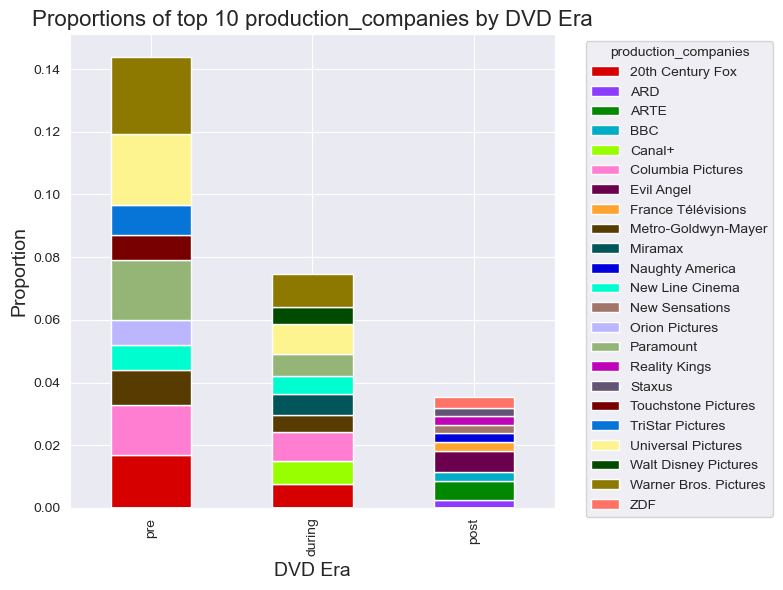

In [234]:
top_10_prod_companies = top_proportions_per_era(df_combined, 'production_companies', 10, True)
plot_top_proportions_per_era(top_10_prod_companies, 'production_companies', 10)

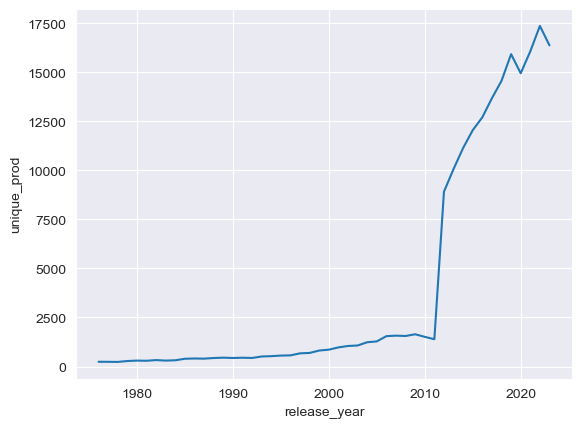

In [235]:
num_production_companies_per_year = df_combined.explode('production_companies').groupby('release_year')['production_companies'].nunique().reset_index(name='unique_prod')
sns.lineplot(data=num_production_companies_per_year, x='release_year', y='unique_prod')
plt.show()

# Countries

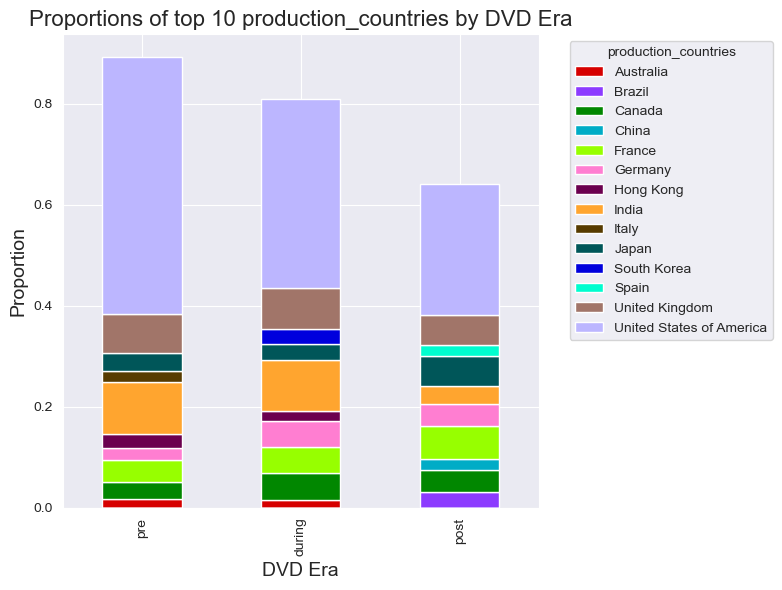

In [236]:
top_10_prod_countries = top_proportions_per_era(df_combined, 'production_countries', 10, True)
plot_top_proportions_per_era(top_10_prod_countries, 'production_countries', 10)

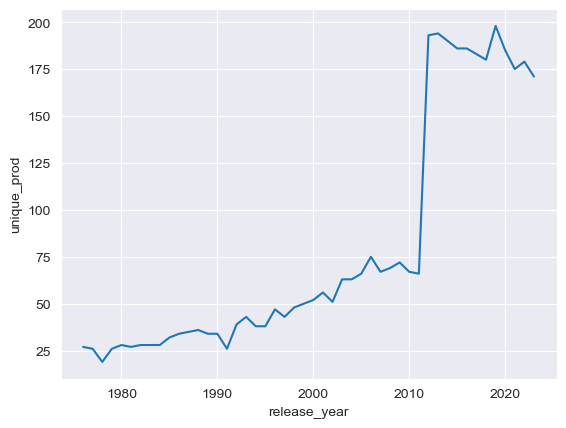

In [237]:
num_production_countries_per_year = df_combined.explode('production_countries').groupby('release_year')['production_countries'].nunique().reset_index(name='unique_prod')
sns.lineplot(data=num_production_countries_per_year, x='release_year', y='unique_prod')
plt.show()

# Original language

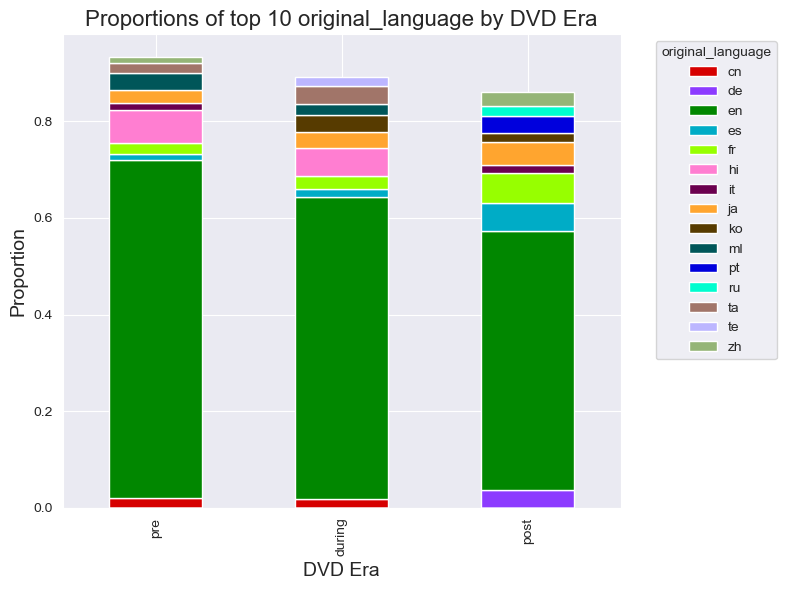

In [238]:
top_10_og_lang = top_proportions_per_era(df_combined, 'original_language', 10)
plot_top_proportions_per_era(top_10_og_lang, 'original_language', 10)

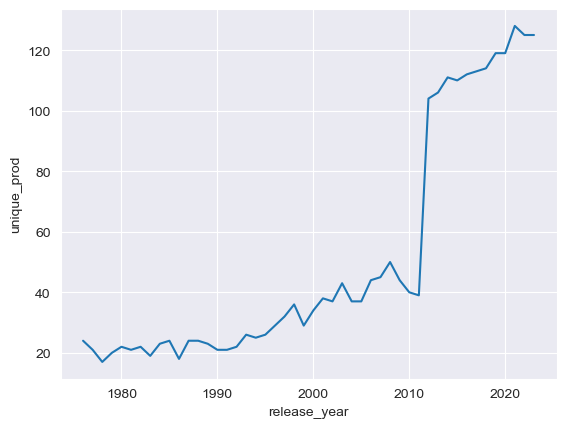

In [239]:
num_lang_per_year = df_combined.groupby('release_year')['original_language'].nunique().reset_index(name='unique_prod')
sns.lineplot(data=num_lang_per_year, x='release_year', y='unique_prod')
plt.show()

In [240]:
num_movies_per_year = df_combined.groupby('release_year').size().reset_index(name='num_movies')
num_movies_per_year

,release_year,num_movies
0,1976,218
1,1977,230
2,1978,242
3,1979,256
4,1980,282
5,1981,254
6,1982,279
7,1983,265
8,1984,297
9,1985,346


In [241]:
num_lang_per_year['ratio'] = num_lang_per_year['unique_prod'] / num_movies_per_year['num_movies']
num_lang_per_year

,release_year,unique_prod,ratio
0,1976,24,0.110092
1,1977,21,0.091304
2,1978,17,0.070248
3,1979,20,0.078125
4,1980,22,0.078014
5,1981,21,0.082677
6,1982,22,0.078853
7,1983,19,0.071698
8,1984,23,0.077441
9,1985,24,0.069364


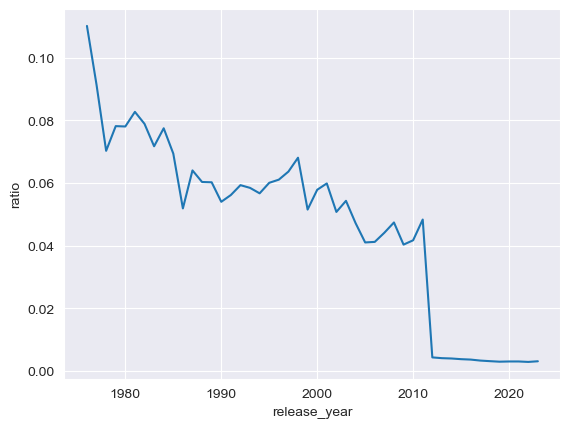

In [242]:
sns.lineplot(data=num_lang_per_year, x='release_year', y='ratio')
plt.show()

# genre


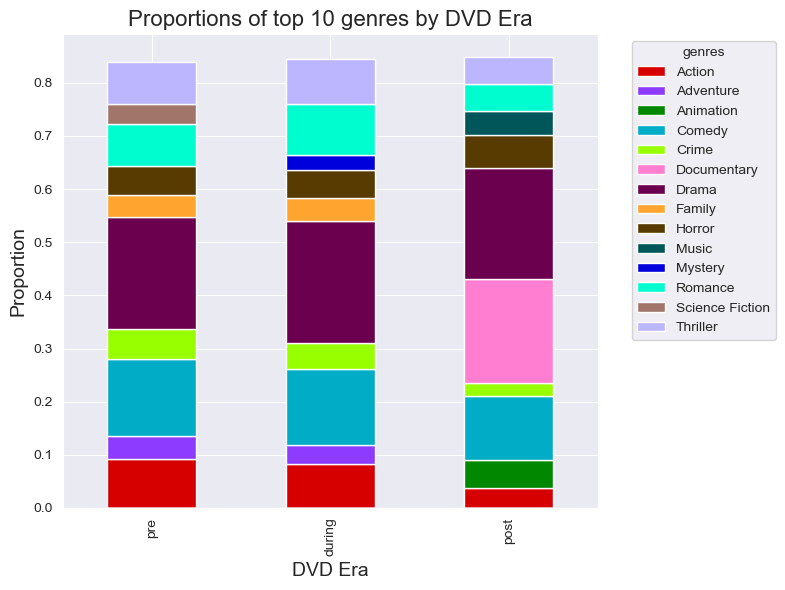

In [243]:
top_10_genre =top_proportions_per_era(df_combined, 'genres', 10, True)
plot_top_proportions_per_era(top_10_genre, 'genres', 10)

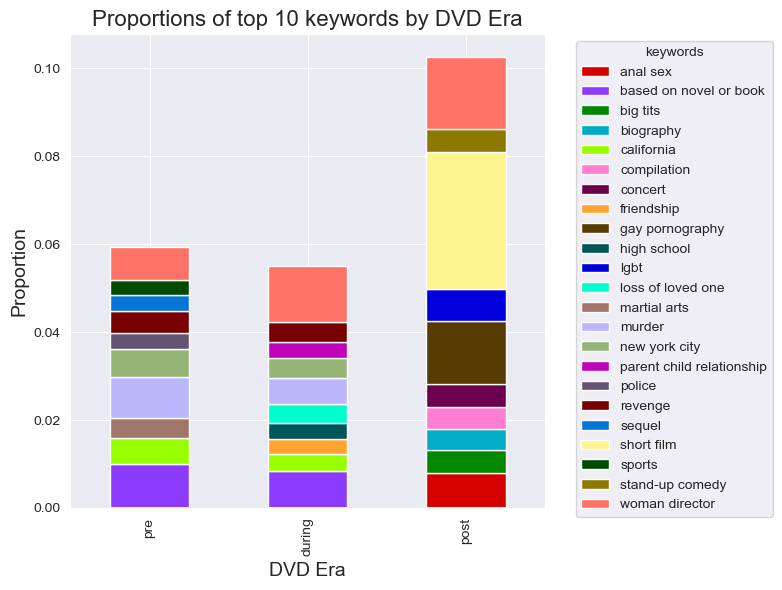

In [244]:
top_10_keyword =top_proportions_per_era(df_combined, 'keywords', 10, True)
plot_top_proportions_per_era(top_10_keyword, 'keywords', 10)

In [245]:
df_combined[df_combined['revenue']>0].groupby('dvd_era').agg(mean_rev=('revenue', 'mean'))

,mean_rev
dvd_era,
during,1.107000e+08
post,5.644045e+07
pre,7.184131e+07


In [246]:
df_combined[df_combined['budget']>0].groupby('dvd_era').agg(mean_rev=('budget', 'mean'))

,mean_rev
dvd_era,
during,2.679935e+07
post,5.832696e+06
pre,1.754062e+07
